<a href="https://colab.research.google.com/github/sophschwartz/ADOSValidation/blob/main/ADOSValidation_INSAR2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Validation of the Autism Diagnostic Observation Schedule with Open-Access Data**
### Independent data analysis of ADOS Files from NDAR
### INSAR 2021
Dr. Sophie Schwartz, Hazel Baker-Harvey, & Dr. Helen Tager-Flusberg



The Autism Diagnostic Observation Schedule (ADOS) has been the gold-standard for autism diagnosis for many years. However, the algorithm items for the ADOS-G [(Lord et al., 2000)](https://drive.google.com/drive/folders/1aNhGCT_p6nNc_CdkcRWfyqwM2Tl8fMqM?usp=sharing) were initially validated on only 223 samples, and later revised based on a new validation set of 1,630 assessments for the ADOS-2 [(Gotham et al., 2007)](https://drive.google.com/drive/folders/1aNhGCT_p6nNc_CdkcRWfyqwM2Tl8fMqM?usp=sharing) that were 
then validated on an independent sample of 1,282 assessments [(Gotham et al., 2008)](https://drive.google.com/drive/folders/1aNhGCT_p6nNc_CdkcRWfyqwM2Tl8fMqM?usp=sharing).


> As a note, any cell beginning '%%capture' has hidden output to ease readability.



#Preparing Your Workspace

For these analyses, you must have the appropriate packages installed and imported and the data from NDAR's database. Googe Colaboratory has several Python packages already installed. This project uses a combination of packages already included in Google Colaboratory and some not included. Here we install any relevant packages.

In [ ]:
%%capture

!pip install factor_analyzer
!pip install kneed

We also need to import relevant packages that are used in these analyses. Some are already included in Google Colaboratory automatically, and are reduntant to import. However, these imports are necessary in other Python processors.

In [ ]:
%%capture

# Basics
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn import *

# Additional Stats Packages
from factor_analyzer import (FactorAnalyzer, ConfirmatoryFactorAnalyzer, 
                             ModelSpecificationParser)
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif_func
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
## two things added as needed for loglik function and table conversion
from sklearn.metrics import log_loss
from tabulate import tabulate
from kneed import KneeLocator

We also need to set plot formatting parameters, like fonts.

In [ ]:
import matplotlib.font_manager
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'axes.labelsize':'large'})
plt.rcParams.update({'axes.titlesize':'large'})

To gather our data, we need to load in the data obtained from the [NIMH Data Archive (NDAR)](https://nda.nih.gov/). This data is accessible to those who submit formal requests. If you would like access to this data, there are instructions on [this website](https://nda.nih.gov/access-data.html).


In [ ]:
# Import local files from user's computer, select files to upload by clicking 'Choose Files'
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ados3_201201.txt to ados3_201201.txt
Saving ados2_201201.txt to ados2_201201.txt
Saving ados1_201201.txt to ados1_201201.txt
User uploaded file "ados3_201201.txt" with length 2034240 bytes
User uploaded file "ados2_201201.txt" with length 1616334 bytes
User uploaded file "ados1_201201.txt" with length 1794960 bytes


Each data file is uploaded as a .txt file. Here we change each to its own Pandas dataframe, with each module as its own dataframe.

In [ ]:
# Substitute for read_tables(filepath) in original Python file
mod1_df = pd.read_csv('/content/ados1_201201.txt', delimiter="\t")
mod2_df = pd.read_csv('/content/ados2_201201.txt', delimiter="\t")
mod3_df = pd.read_csv('/content/ados3_201201.txt', delimiter="\t")

#Selecting Relevant Data

Next we begin the cleaning of data and selecting relevant variables from the dataframes. First we set demographics columns (consisting of a subject identifier, age, and sex) and a diagnostic column (which consists of the number code denoting autism diagnosis, and clinical impression). These columns will be the same for all mods.

In [ ]:
demographics = ['subjectkey', 'interview_age', 'sex']
diagnostic = ['scoresumm_adosdiag','scoresumm_overalldiag']

For this project, we only use certain columns that contain coded items. extract_variables selects coding variables, demographics variables, and diagnostic variables of interest across all three modules.

In [ ]:
def extract_variables(mod_df):
  """
  Extract variables from NDAR ADOS dataframes that are of interest.
  ADOS Module 1-3:
      Demographic variables: subjectkey, interview_age, sex
      Code ratings variables: Select anything with prefix 'coding',
      except remove suffix '_cmt' items (comments)
      Total Diagnostics: scoresumm_adosdiag (result from ADOS),
      scoresumm_overalldiag (clinical impression)
  Parameters
  ----------
  df : Pandas DataFrame
      dataframe of all data from text file.
  Returns
  -------
  new_df : Pandas DataFrame
      dataframe with only variables of interest as defined above.
  mod_codes : List of strings.
      list of column names for coding information.
  """

  mod_codes = [x for x in mod_df.columns[mod_df.columns.str.contains('coding')] 
              if not any(ignore in x for ignore in ['cmt'])]
  columns_to_keep = demographics + diagnostic + mod_codes
  new_df = mod_df[[c for c in mod_df.columns if c in 
                   columns_to_keep]]
  return new_df        

We use the above function to reduce the dataframes to only relevant variables.

In [ ]:
mod1_df = extract_variables(mod1_df)
mod2_df = extract_variables(mod2_df)
mod3_df = extract_variables(mod3_df)

We next select only ADOS codes that are common across all three ADOS-2 Modules (1-3). Here we create two column sets, 1) Similar columns: List of strings that occur across modules 1-3 as they appear in the original data 2) All module columns: renames common codes for coherence. Both lists are combined with the demographics and diagnostic columns already defined. 

In [ ]:
# Part of condense_modules in original Python file
similar_coding_columns = ['inton','spabn', 'iecho', 'stereo', 'gest', 'ueye',
                   'faceo', 'facee', 'shrnj', 'qsov', 'asove',
                   'codingb_asov_c', 'qsres', 'imgcr', 'usens',
                   'oman', 'selfinj', 'urbeh', 'topic', 'actve',
                   'agg', 'anxty']
all_coding_columns = ['inton', 'echo',
                    'stereo_lang', 'gest', 'eye_cont', 'facial_exp',
                    'shared_enj', 'soc_overture', 'exp_attn', 'response',
                    'imag', 'sensory', 'mannerisms', 'selfinj', 'rrb',
                    'active', 'agg', 'anx']    

# Generates list of the common appearances of column names for all mods
similar_columns = demographics + similar_coding_columns + diagnostic

# Generates list of what columns will be named to in all modules to combine data sets
all_mods_columns = demographics + all_coding_columns + diagnostic

condense_modules selects the relevant codes from each module's dataframe, using the similar_columns list created above as a guide. Renames each column using the all_mods_columns list above to allow for easy dataframe combination.

In [ ]:
def condense_modules(mod_df, mod_n):
  """
  Condense dataframes across all modules with the same 18 codes. 
  Will allow one large analysis of all data across all modules.
  
  Parameters
  ----------
  mod_df : Pandas DataFrame
      dataframe that includes subjectkey, interview_age, sex, and 
      scoresumm_adosdiag, scoresumm_overalldiag, and coding items as variables.
  mod_n : Integer
      integer of module number for specific dataframe parameter.
  Returns
  -------
  new_df : Pandas DataFrame 
      dataframe with demographic codes, diagnostic labels, and
      condensed number of ADOS coding variables.
  """
  condensed_cols = [col for col in mod_df.columns if any(
        code_str in col for code_str in similar_columns)]
  new_df = mod_df[condensed_cols]
  new_df.columns = all_mods_columns
  new_df = new_df.assign(Module=mod_n)
  return new_df

We call the condense_modules function to select common codes from each dataframe.

In [ ]:
mod1_df = condense_modules(mod1_df, 1)
mod2_df = condense_modules(mod2_df, 2)
mod3_df = condense_modules(mod3_df, 3)

#Cleaning the Data

The function clean_data is the first step in cleaning each individual module's dataframe. It removes any rows with missing data, fixes common typos, etc.

In [ ]:
def clean_data(mod_df):
  """
  Cleans data by editing typos, removing missing data entries, etc.
  
  Parameters
  ----------
  df : Pandas Dataframe
      dataframe including coding variables and score variables.
  Returns
  -------
  df : Pandas Dataframe
      dataframe with
      1) Fixes typos and inconsistent entries
      2) Removes missing data
  """
  df = mod_df.drop([0])

  # Make all items lower case
  df.scoresumm_adosdiag = df.scoresumm_adosdiag.str.lower()
  df.scoresumm_overalldiag = df.scoresumm_overalldiag.str.lower()

  # remove invalid or missing entries
  nan_strings = ['9', 'n/a', 'low', '3', 'na']
  for string in nan_strings:
    df.loc[df['scoresumm_adosdiag'].str.contains(string),
           'scoresumm_adosdiag'] = ''
  df.scoresumm_adosdiag = df.scoresumm_adosdiag.replace(to_replace='', value=np.nan)

  # Drop remaining nan values across dataset
  df = df.dropna()

  # Replace nonspectrum alternative names
  nonspectrum_options = ['language delay', '0', 'no', 'typ', 'no diagnosis','low']
  for string in nonspectrum_options:
    df.loc[df['scoresumm_adosdiag'].str.contains(string),
               'scoresumm_adosdiag'] = 'nonspectrum'

  # Replace misspellings of spectrum
  spectrum_misspelled = ['specturm', 'spectum', 'sepctrum']
  for string in spectrum_misspelled:
    df.scoresumm_adosdiag.replace({string: 'spectrum'}, regex=True, 
                                      inplace=True)

  # Replace variations of autism spectrum
  autism_spectrum_options = ['aurism', 'autsim', 'autim', 'austism',
                             'autisim', 'austim', 'asd',
                             'autism spectrum disorder', '1',
                             'autism  spectrum', 'autism-spectrum',
                             'autism spect', 'autism spectrum',
                             'autismspectrum', 'moderate',
                             'medium', 'pdd', '2', 'high',
                             'autistic disorder', 'aut']
  for string in autism_spectrum_options:
        df.loc[df['scoresumm_adosdiag'].str.contains(string),
               'scoresumm_adosdiag'] = 'autism spectrum'

  # Replace 'spectrum' and 'aut' with 'autism spectrum'; note: must match
  # exactly so as to avoid replacing nonspectrum with autism spectrum
  df.scoresumm_adosdiag.replace(to_replace='spectrum',
                                    value='autism spectrum', inplace=True)

  # Remove any participant with an age of less than 13 months 
  # or more than 191 months. Invalid assessment age.
  df = df[df['interview_age'].astype('int32') > 13]
  df = df[df['interview_age'].astype('int32') < 192]

  # Address errors in data: items with a value of 3 when 3 not an option.
  # Replace with 2.
  df.eye_cont.replace(to_replace='3', value='2', inplace=True)
  df.gest.replace(to_replace='3', value='2', inplace=True)

  # Remove scores of 9 and 8 from dataset, considered missing data.
  mapper = {'9': np.nan, '8': np.nan}
  df.replace(mapper, inplace=True)
  df= df.dropna()

  # While 7s can be valid scores, they will not be used in this analysis.
  # Replace 7's with nan data, then removes those from data set
  mapper = {'7': np.nan}
  df = df.replace(mapper)
  df = df.dropna()
  
  clinical_other_options = ['delay', 'global', 'gdd', 'adhd', 'anxiety']
  for string in clinical_other_options:
    df.loc[df['scoresumm_overalldiag'].str.contains(string),
           'scoresumm_overalldiag'] = 'Global Intellectual Impairment'

  return df

We call the above clean_data function for each of the modules' dataframes.

In [ ]:
mod1_df = clean_data(mod1_df)
mod2_df = clean_data(mod2_df)
mod3_df = clean_data(mod3_df)

#Format the Data Types

Here, we format each column to ensure each value is considered either ordinal or categorical. This will aid with combining dataframes and later analyses.

In [ ]:
def format_datatypes(df, coding):
    """
    Format DataFrame so values are all considered categorical or ordinal.

    Relabel autism_diagnosis: 0 as autism, 1 as td (categorical int32)
    Reformat ados codes from object to ordinal int64 between 0 and 3.

    Parameters
    ----------
    df : Pandas DataFrame
        dataframe including coding, demographics, and scoring variables,
        pre-formatted.

    Returns
    -------
    df : Pandas DataFrame
        formatted dataframe.
    """
    # Converts the interview age to int32 type of data
    df['interview_age'] = df['interview_age'].astype('int32')
    # Converts sex to categorical data
    df['sex'] = df['sex'].astype('category')

    # Assigns all code values as int64 type of data
    df[coding] = df[coding].apply(
        lambda x: x.astype('int64'))

    # Creates int32 one-hot coding of data as either 0 (autism) or 1 (td)
    # for variable scoresumm_adosdiag
    lbe = LabelEncoder()
    df[diagnostic[0]] = lbe.fit_transform(
        df[diagnostic[0]])

    return df

In [ ]:
mod1_df = format_datatypes(mod1_df, all_coding_columns)
mod2_df = format_datatypes(mod2_df, all_coding_columns)
mod3_df = format_datatypes(mod3_df, all_coding_columns)

Now that all the data has been similarly cleaned and formatted, all the modules are combined into one completed data set.

In [ ]:
all_mods = pd.concat([mod1_df, mod2_df, mod3_df])

#Summary Statistics

The function summ_stats returns two Pandas dataframes with summary stats on age and gender grouped by both diagnosis and module.



In [ ]:
def summ_stats(df):
  """
  Summary stats pulled from dataframe
  
  Parameters
  ----------
  df : Pandas DataFrame
      formatted dataframe with relevant variables.
  Returns
  -------
  sex_summ : Pandas Dataframe 
      dataframe of sex stats by module and diagnosis.
  age_summ : Pandas Dataframe 
      dataframe of age stats by module and diagnosis.
  """
  sex_summ = df.groupby([ 'Module','scoresumm_adosdiag'])['sex'].value_counts()
  age_summ = df.groupby(['Module','scoresumm_adosdiag'])['interview_age'].describe()

  return sex_summ, age_summ

The function descriptive table helps to visualize the results of summary stats.

In [ ]:
def descriptive_table(sex, age):
  """
  Generates a table of results from summary stats.
  
  Parameters
  ----------
  sex : Pandas Dataframe 
      dataframe generated from summ_stats
  age : Pandas Dataframe 
      dataframe generated from summ_stats
  Returns
  ----------
  None
  """

  table = go.Figure(data=[go.Table(
      columnwidth = [500],
  header=dict(values= ['Module','Diagnosis','Count', 'N of Females',
                       'Age \n (months, mean)', 'Age \n (months, std)'],
              line_color='red', fill_color='lightblue', align=['center', 'center'],
              font_size = 20, height=40),
  cells = dict(values=[['Mod 1','','Mod 2','','Mod 3',''],
                       ['Autism', 'Nonspectrum', 'Autism', 'Nonspectrum','Autism', 'Nonspectrum',],
                       [age['count'].loc[1,0],age['count'].loc[1,1], age['count'].loc[2,0],
                        age['count'].loc[2,1], age['count'].loc[3,0], age['count'].loc[3,1]],
                       [sex.loc[1,0,'F'],sex.loc[1,1,'F'],sex.loc[2,0,'F'],sex.loc[2,1,'F'],
                        sex.loc[3,0,'F'], sex.loc[3,1,'F']],
                       [round(age['mean'].loc[1,0],2), round(age['mean'].loc[1,1],2), round(age['mean'].loc[2,0],2), 
                        round(age['mean'].loc[2,1],2),round(age['mean'].loc[3,0],2), round(age['mean'].loc[3,1],2)],
                       [round(age['std'].loc[1,0],2), round(age['std'].loc[1,1],2), round(age['std'].loc[2,0],2), 
                        round(age['std'].loc[2,1],2),round(age['std'].loc[3,0],2), round(age['std'].loc[3,1],2)]],
               line_color='red', fill_color='white', align='center',
               font_size=18, height=40))])
  table.update_layout(width=1000, height=525)
  table.show()


Here, we see the results of the summary stats visualized.

In [ ]:
sex, age = summ_stats(all_mods)
descriptive_table(sex, age)

We can also visualize the age distribution with a histogram. The below function will generate a histogram of ages separated by diagnosis.

In [ ]:
def age_hist(df):
  """
  Generates a histogram of age distribution within the data.
  
  Parameters
  ----------
  df : Pandas Dataframe 
      dataframe of coding, demographic, and score variables.
  Returns
  ----------
  None
  """
  fig, ax = plt.subplots()
  c = 0
  color_queue = ['r', 'b']
  for (diagnosis, data) in df.groupby('scoresumm_adosdiag'):
    data['interview_age'].hist(alpha=0.7, ax=ax, label=diagnosis, color=color_queue[c])
    c = c + 1
  sample_size = str(df.shape[0])
  ax.legend(['Autism', 'Nonspectrum'])
  max_hist_value = df['interview_age'].max()
  plt.xlim((0, int(math.ceil(max_hist_value / 10)) * 10))
  # Note: may need to edit ylim values for your data
  plt.ylim((0, 2000))
  plt.title('Histogram of Age and Group (N = ' + sample_size + ') \n')
  plt.xlabel('Age (months)')
  plt.ylabel('Frequency')
  plt.savefig('AgeByGroupHistogram.png', format='png')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


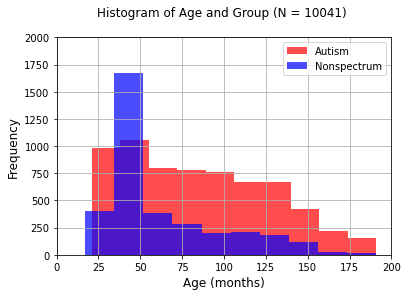

In [ ]:
age_hist(all_mods)

#Factor Analysis

##Determining Fitness

Before conducting factor analyses, we perform a Bartlett's test to determine if factor analysis is appropriate for this sample. Here we hope to see that any correlations in our data are not significant. The below function will return the chi square value result of the Bartlett's test and the p value of the test.

In [ ]:
def bartlett(df):
  """
  Performs Bartlett's test on data, to determine appropriateness of factor analysis.

  ----------
  df : Pandas DataFrame
      dataframe of dataset to be analyzed in Bartlett's test.
  Returns
  -------
  chi_square_value : Float
      number value, result of test.
  p_value : Float
      value number, result of test
  """
  x_fact = df[all_coding_columns]
  chi_square_value, p_value = calculate_bartlett_sphericity(x_fact)
   
  return chi_square_value, p_value

Calling the above function for our data, we see that our p_value is 0.0. We can perform factor analysis with this data.

In [ ]:
bartlett(all_mods)

(58812.1517399619, 0.0)

Next we explore the data with a scree plot. A scree plot can be used to visually determine the optimal number of factors for a data set. The function below generates a scree plot for our data, plotting the eigenvalue by the number of factors.

In [ ]:
def scree(df):
    """
    Scree plot for elbow method to determine number of factors to consider.
    
    Parameters
    ----------
    df : Pandas DataFrame
       dataframe of dataset to be plotted.
    Returns
    -------
    None
    """

    x_fact = df[all_coding_columns]

    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer()
    fa.fit(x_fact)
    # Check Eigenvalues
    eigen_values, vectors = fa.get_eigenvalues()
    ncomponents = len(eigen_values[eigen_values > 1])

    # Create scree plot using matplotlib
    plt.figure()
    plt.scatter(range(1, x_fact.shape[1]+1), eigen_values)
    plt.plot(range(1, x_fact.shape[1]+1), eigen_values)
    plt.xticks(np.arange(0, x_fact.shape[1], step=2))
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')

    # Assess variance of each factors and determine how much cumulative
    # variance is explained by diff number of factors
    for ncomp_range in range(1, ncomponents+1):
        fa = FactorAnalyzer()
        fa.set_params(n_factors=ncomp_range, rotation="promax")

    return

Here we see that the generated scree plot suggests the features of our data would fit well into a one or two factor model.

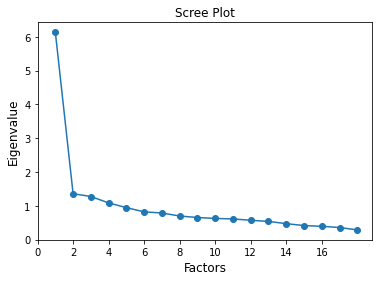

In [ ]:
scree(all_mods)

##Exploratory Factor Analysis

To perform Exploratory Factor Analysis (EFA), the [Factor Analyzer package](https://pypi.org/project/factor-analyzer/) was utilized. This allowed us to explore which ADOS items mapped onto which factor.

The below function performs exploratory multi-factor analysis with a default promax rotation where appropriate. The function produces tables of eigenvalues for each number of factors, loadings of each variable, communalities of each variable, and the common eigenvalues. Note: Most often, factors are rotated after extraction. This can ensure that the factors are orthogonal (i.e., uncorrelated), which eliminates problems of multicollinearity in regression analysis. Eigenvalues represent the total amount of variance that can be explained by a given factor. Those close to zero imply item collinearity.

In [ ]:
def factor_analysis(df, nFactors, coding):
    """
    Performs exploratory factor analysis on the given data set.

    Parameters
    ----------
    df : Pandas DataFrame
    nFactors : Integer 
        number indicating number of factors to use for analysis.
    coding : List of strings 
        list indicating column names for coding.
        variables
    Returns
    -------
        efa_loadings : Array
            Factor loadings of all variables
        factor_comm : Array
            Communalities of all variables
        orig_ev : Array
            Eignevalies of all variables
        common_ev : Array
            Common eigenvalues of all variables
        model_dict : Dictionary
            dictionary of factor number and relevant item names
        all_high_loadings : Set
            Set of items that contribute above .5 to factor
    """
    # Limit columns of dataframe to only coding variables
    toAnalyze = df[coding]

    # default of FactorAnalyzer = 3, default is promax rotation
    efa = FactorAnalyzer(n_factors=nFactors)

    # Performs exploratory factor analysis
    # Defaults to using SMC
    efa.fit(toAnalyze)

    # Gives you the factor loading matrix
    # The factor loading is a matrix which shows the relationship of each variable to the underlying factor.
    # It shows the correlation coefficient for observed variable and factor.
    # It shows the variance explained by the observed variables.
    efa_loadings = efa.loadings_
    high_loadings = efa_loadings > 0.5

    model_dict = dict()
    all_high_loadings = set()
    for fac in range(0, nFactors):
        cur_loading = high_loadings[:, fac]
        cols_high_loading = list(
            itertools.compress(coding, cur_loading))
        model_dict[str(fac+1)] = cols_high_loading
        all_high_loadings.update(cols_high_loading)


    # Return array of communalities, given loadings
    # Proportion of each variable's variance explained by the factors
    # Commonalities are the sum of the squared loadings for each variable.
    # It represents the common variance.
    # It ranges from 0-1 and value close to 1 represents more variance.
    factor_comm = efa.get_communalities()
    #factorComm.insert(0,'Factor Communalities')

    # Returns both original and common eigen values
    # Eigenvalues represent variance explained each factor from the total variance.
    # It is also known as characteristic roots.
    orig_ev, common_ev = efa.get_eigenvalues()

    # Other potential returns of interest, currently commented out
    #factorVar, propVar, cumVar = efa.get_factor_variance()
    #factorUniq = efa.get_uniquenesses()

    return efa_loadings, factor_comm, orig_ev, common_ev, model_dict, all_high_loadings


###One Factor Model

Here, we call the function to perform exploratory factor analysis for a one factor model.

In [ ]:
efa1_loadings, factor1_comm, orig1_ev, common1_ev, model1_dict, \
    all_high_loadings_f1 = factor_analysis(all_mods, 1, all_coding_columns)


/usr/local/lib/python3.7/dist-packages/factor_analyzer/factor_analyzer.py:626: UserWarning:

No rotation will be performed when the number of factors equals 1.



To visualize the factor loading results of these analyses, we make a table that plots the high loadings of each factor.



In [ ]:
def factor1_table(loadings, coding, title):
  """
  Generates a chart mapping the variables and their loadings of the core feature
  model.

  Parameters
  ----------
  loadings : Array 
      Array of values assigned to each variable
  coding : List of strings
      list of all coding items
  title : String
      title to be used on table
  Returns
  ----------
  None
  """

  loadings_labeled = pd.concat([pd.DataFrame(loadings), pd.DataFrame(coding)], axis = 1)
  loadings_labeled.columns = ['Loading', 'Code Feature']
  loadings_labeled.sort_values(by = 'Loading', ascending=False, inplace=True)
  loadings_labeled = loadings_labeled[loadings_labeled['Loading']>0.5]

  sns.set_context('paper', font_scale=4)
  plt.rcParams['font.sans-serif'] = 'Arial'
  plt.rcParams['font.family'] = 'sans-serif'
  plt.rcParams['text.color'] = '#000000'
  plt.rcParams['axes.labelcolor']= '000000'
  plt.rcParams['xtick.color'] = '#000000'
  plt.rcParams['ytick.color'] = '#000000'
  sns.color_palette("Blues")
  plt.figure(figsize=(10,11));
  ax = sns.barplot(x = 'Loading', y='Code Feature', data=loadings_labeled,
                    palette=sns.light_palette(
                        (210, 90, 60), n_colors=15, input="husl",
                        reverse=True))
  plt.title(title, size = 50)
  ax.set_xlabel('Loadings', size = 50)
  ax.set_ylabel('ADOS Items', size = 50)
  ax.set_yticklabels(loadings_labeled['Code Feature'], ha="left")
  ax.tick_params(axis="y",direction="in", pad=-40)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


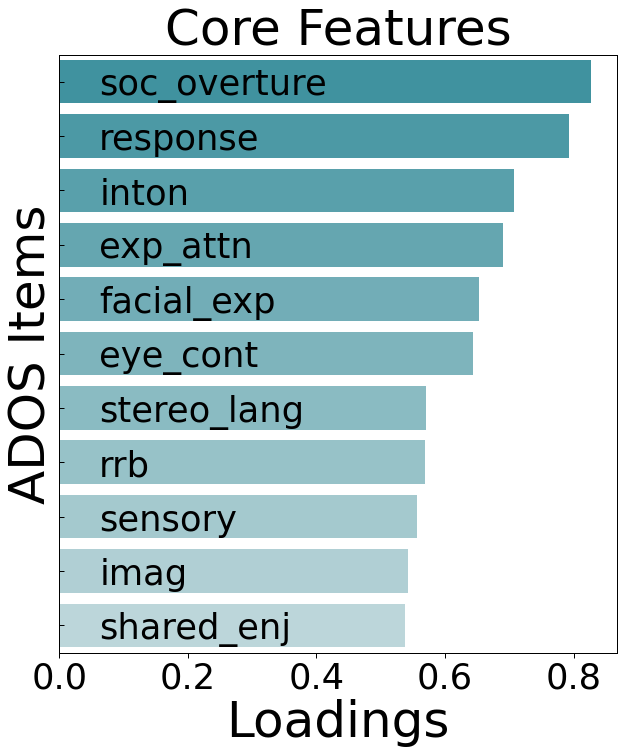

In [ ]:
# Note if running with fake data, error occurs as part of Seaborn color package.
factor1_table(efa1_loadings, all_coding_columns, 'Core Features')

###Two Factor Model

Here, we call the function to perform confirmatory factor analysis for a two factor model.

In [ ]:
efa2_loadings, factor2_comm, orig2_ev, common2_ev, model2_dict, \
    all_high_loadings_f2 = factor_analysis(all_mods, 2, all_coding_columns)

To visualize the factor loading results of these analyses, we make a table that plots the high loadings of each factor.


In [ ]:
def factor2_table(loading_values, sa_items, rrb_items):
  """
  Generates two charts mapping the variables and their loadings of the two feature
  model.

  Parameters
  ----------
  loadings_values : Pandas Dataframe 
      dataframe of values  assigned to each variable
  sa_items : List of strings
      list of all coding items
  rrb_items : String
      title to be used on table
  Returns
  ----------
  None
  """
  loadings_1  = loading_values.loc[
      loading_values['Code Feature'].isin(
          sa_items)].sort_values(by = 'Loading 1', ascending = False)
  # Create graph of feature importance for Factor 1
  sns.set_context('paper', font_scale=4)
  plt.rcParams['font.sans-serif'] = 'Arial'
  plt.rcParams['font.family'] = 'sans-serif'
  plt.rcParams['text.color'] = '#000000'
  plt.rcParams['axes.labelcolor']= '000000'
  plt.rcParams['xtick.color'] = '#000000'
  plt.rcParams['ytick.color'] = '#000000'
  sns.color_palette("Blues")
  plt.figure(figsize=(10, 10));
  ax = sns.barplot(x = 'Loading 1', y='Code Feature', data=loadings_1,
                    palette=sns.light_palette(
                        (210, 90, 60), n_colors=15, input="husl",
                        reverse=True))
  plt.title('Social Features', size = 50)
  ax.set_xlabel('Loadings', size = 50)
  ax.set_ylabel('ADOS Items', size = 50)
  ax.set_yticklabels(loadings_1['Code Feature'], ha="left")
  ax.tick_params(axis="y",direction="in", pad=-40)   

  loadings_2  = efa2_loadings_labeled.loc[
      efa2_loadings_labeled['Code Feature'].isin(
          rrb_items)].sort_values(by = 'Loading 2', ascending = False)
  # Create graph of feature importance for Factor 1
  plt.figure(figsize=(10, 10));
  ax = sns.barplot(x = 'Loading 2', y='Code Feature', data=loadings_2,
                    palette=sns.light_palette(
                        (210, 90, 60), n_colors=13, input="husl",
                        reverse=True))
  plt.title('Restricted Features', size = 50)
  ax.set_xlabel('Loadings', size = 50)
  ax.set_ylabel('ADOS Items', size = 50)
  ax.set_yticklabels(loadings_2['Code Feature'], ha="left")
  ax.tick_params(axis="y",direction="in", pad=-40)
  return

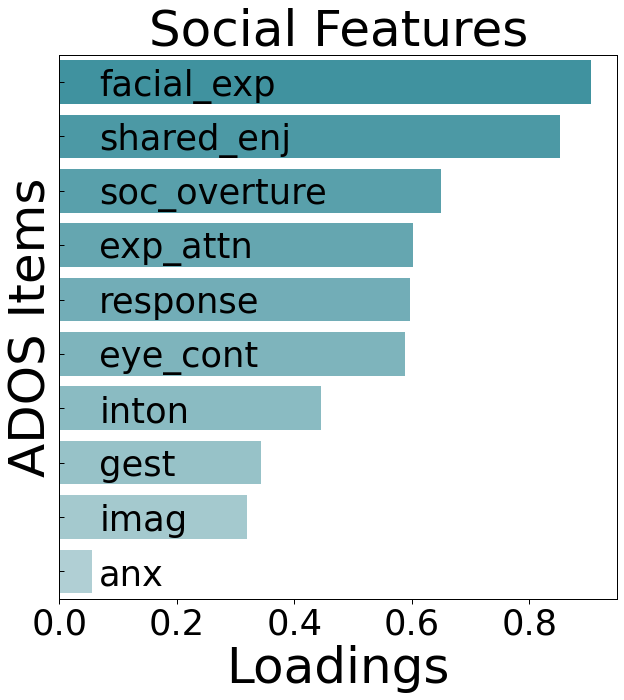

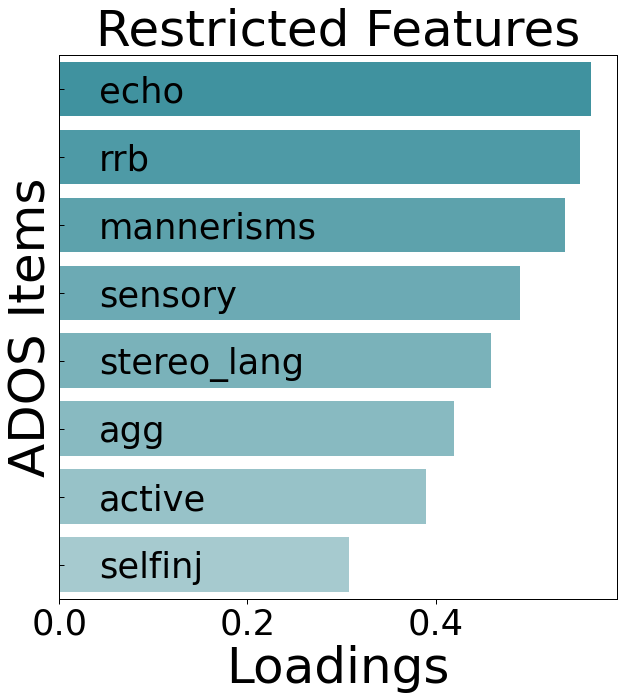

In [ ]:
efa2_loadings_labeled = pd.concat([pd.DataFrame(efa2_loadings), pd.DataFrame(all_coding_columns)], axis = 1)
efa2_loadings_labeled.columns = ['Loading 1', 'Loading 2', 'Code Feature']
rrb_items = ['echo', 'stereo_lang', 'sensory',
                     'mannerisms', 'selfinj', 'rrb', 'active', 'agg']
sa_items = ['inton', 'gest', 'eye_cont', 'facial_exp', 'shared_enj',
                'soc_overture', 'exp_attn', 'response','imag', 'anx']
          
factor2_table(efa2_loadings_labeled, sa_items, rrb_items)

##Confirmatory Factor Analysis

Confirmatory Factor Analysis (CFA) is performed following EFA to determine goodness of fit of the explored model. 

In [ ]:
def con_factor_analysis(df, model_dict, all_high_loadings):
    """
    Performs confirmatory factor analyses with the determined factor model and
    selected variables.

    Parameters
    ----------
    df :  Pandas DataFrame
    model_dict : Dictionary
      dictionary with factors and high-loaded variables.
    all_high_loadings : List of strings 
        list with all column names of variables
        included in factor analysis.
    Returns:
        cfa_factor_loadings : Pandas DataFrame
            dataframe with factor loadings of variables.
    """

    # Remove unneccessary columns in new df
    toAnalyze = df[list(all_high_loadings)]

    model_spec = ModelSpecificationParser.parse_model_specification_from_dict(
        toAnalyze, model_dict)

    # Performs confirmatory factor analysis
    cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False)
    cfa.fit(toAnalyze)

    # Gives you the factor loading matrix
    # The factor loading is a matrix which shows the relationship of each
    # variable to the underlying factor.
    # It shows the correlation coefficient for observed variable and factor.
    # It shows the variance explained by the observed variables.
    cfa_factor_loadings = cfa.loadings_

    print(cfa.factor_varcovs_)
    cfa.transform(toAnalyze.values)

    return cfa_factor_loadings

### One Factor Model

Here, we call the function to perform confirmatory factor analysis for a one factor model.

In [ ]:
cfa1_factor_loadings = con_factor_analysis(
    all_mods, model1_dict, all_high_loadings_f1)

[[1.]]


###Two Factor Model

Here, we have the function perform confirmatory factor analysis for a two factor model.

In [ ]:
cfa2_factor_loadings = con_factor_analysis(
    all_mods, model2_dict, all_high_loadings_f2)

[[1.         0.81360474]
 [0.81360474 1.        ]]


/usr/local/lib/python3.7/dist-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning:

The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'



##Additional Validation in R

Another method of performing statistical analyses of data is through R, another open source programming language. Here, we demonstrate how the [Lavaan](https://www.lavaan.ugent.be/) package can help perform confirmatory factor analysis  (CFA).

These analyses were intially performed in R-studio. In Colaboratory, R can be processed as written below. Note: this would not work in other Python processors.

In [ ]:
%load_ext rpy2.ipython

We must install the packages semTools, Lavaan, and foreign for these analyses.

In [ ]:
%%capture
%%R

install.packages("semTools")
install.packages("lavaan", dependencies=TRUE)
install.packages("foreign", dependencies = TRUE)

This verifies that the correct packages are installed and active.

In [ ]:
%%capture
%%R

library(foreign)
library(lavaan)

Here, we export the data used in previous 
Python analyses to csv files, thus making them accessible to R. These tables consist of the variables contributing to any and all factors in both models.

In [ ]:
all_mods[all_high_loadings_f1].to_csv('factor1R.csv')
all_mods[all_high_loadings_f2].to_csv('factor2R.csv')

R reads in the data tables.

In [ ]:
%%capture
%%R
factor1r <- read.csv('factor1R.csv')
factor2r <- read.csv('factor2R.csv')

After defining each model's contributing variables, confirmatory factor analyses is performed on each data set with the correctly corresponding models. The Lavaan package produces several results to aid in verifying goodness of fit of each model. Of note, both the one factor model and the two factor common code model have an RMSEA of above .09, and a Confidence of Fit Interval (CFI) of above .9.

In [ ]:
%%R
factor1.model <- ' CORE  =~ inton + stereo_lang + eye_cont + facial_exp + shared_enj + soc_overture + exp_attn + response + imag + sensory + rrb '

factor2.model <- ' SA2  =~ eye_cont + facial_exp + shared_enj + soc_overture + exp_attn + response \
                RRB2 =~ echo + mannerisms + rrb  '
              
fit1 <- cfa(factor1.model, data = factor1r, std.lv=TRUE)
fit2 <- cfa(factor2.model, data = factor2r, std.lv=TRUE)

summary(fit1, fit.measures=TRUE, standardized=TRUE)
print(fitmeasures(fit1, c('cfi','rmsea')))
load1 <- inspect(fit1,what="std")$lambda

summary(fit2, fit.measures=TRUE, standardized=TRUE)
print(fitmeasures(fit2, c('cfi','rmsea')))
load2 <- inspect(fit2,what="std")$lambda

ev1 <- eigen(cor(factor1r))
print(ev1)
ev2 <- eigen(cor(factor2r))
print(ev2)


print(coef(fit1))
print(coef(fit2))

fitMeasures(fit1)


lavaan 0.6-8 ended normally after 24 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        22
                                                      
  Number of observations                         10041
                                                      
Model Test User Model:
                                                      
  Test statistic                              3884.422
  Degrees of freedom                                44
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                             45883.597
  Degrees of freedom                                55
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.916
  Tucker-Lewis Index (TLI)                       0.895

Loglikelihood and Information Criteri

#Unsupervised Clustering

##Preparing the Dataset

For the following analyses, data was split into training and test sets based on the generated Dictionaries from Exploratory Factor Analysis.

A train/test split approach is appropriate for datasets over 500 rows. Stratification done to allow for the same proportion of 0, 1 yes target names.

Data were split into 80% training, 20% test sets.

In [ ]:
def split_dataset(df, col_coding, col_diag):
    """
    Splits given data set into predictor x set and predicted y sets.
    Splits the data into 80% for training, and 20% for testing.
    Parameters
    ----------
    df : Pandas Dataframe
    col_coding : List of strings
        list of column string names containing
        independent variable codes used to predict diagnosis.
    col_diag : List of strings
        lsit of column names relating to diagnoses
    Returns
    -------
    x_train : Pandas Dataframe 
        with int64 data types
    x_test : Pandas Dataframe 
        with int64 data types
    y_train : Pandas Dataframe 
        with int64 data types
    y_test : Pandas Dataframe 
        with int64 data types
    """

    y = df[col_diag]
    x = df[col_coding]
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x, y, test_size=0.2, stratify=y)
    
    return x_train, x_test, y_train, y_test

Additionally, variation inflation factors (vif) are calculated in multicollinearity check within the split data. This is performed to verify the relatedness of each factor. Generally, a vif of more than 1 indicates moderate correlation, and a vif of more than 5 indicates high correlation.

In [ ]:
def multicollinearity_check(x_train):
  """
  Function assesses the relatedness of each factor, used to examine correlation

  Parameters
  ----------
  x_train : Pandas Dataframe
      dataframe from split dataset
  Returns
  -------
  vif : Pandas Dataframe
      dataframe of vif 
  """
  x_temp = sm.tools.tools.add_constant(x_train)
  vif = pd.DataFrame()
  vif['vif factor'] = [vif_func(x_temp.values, i) for i in range(
      x_temp.values.shape[1])]
  print('multicollinearity vif factor:', vif)
  return vif

###One Factor Model

Here we split the data based on a one factor model and run a multicollinearity check on the split data. Here we can see no variables are highly correlated, but many are moderately correlated.

In [ ]:
x_train_1f, x_test_1f, y_train_1f, y_test_1f = split_dataset(
    all_mods, list(all_high_loadings_f1), diagnostic[0])
vif_check = multicollinearity_check(x_train_1f)

multicollinearity vif factor:     vif factor
0     3.487673
1     1.589177
2     1.798962
3     1.436508
4     2.429897
5     1.550280
6     1.458147
7     1.982950
8     2.711890
9     1.393173
10    1.921281
11    1.896681


###Two Factor Model

Here we split the data based on a two factor model and run a multicollienarity check on the split data. Again, many are moderately correlated but none are strongly correlated. Note that variables across both factors were combined into a single list.

In [ ]:
x_train_2f, x_test_2f, y_train_2f, y_test_2f = split_dataset(
    all_mods, list(all_high_loadings_f2), diagnostic[0])
vif_check = multicollinearity_check(x_train_2f)

multicollinearity vif factor:    vif factor
0    3.369118
1    1.637621
2    1.702320
3    1.231200
4    2.308274
5    1.261683
6    1.401223
7    2.603640
8    1.883832
9    1.836522


##Logistic Regression



Next, we perform logistic regression to classify those with ASD and those without ASD based on the items included in our factor analysis. 

Notes on Logistic Regression:
1. Logistic regression is only possible if ADOS codes are either one-hot encoded or
treated as continuous/ordinal data. In this analysis, they are ordinal.
2. Logistic regression performed for a single factor at a time.
3. Use x values identified as predictive from factor analysis.
4. Run a logistic regression with all identified variables and return accuracy.
5. Sum the raw scores across variables to create a single x-axis predictor.
6. Run second regression and plot
7. Using l2 regularization to force weights to be small but doesn't make
them zero. Is particularly better for multicollinearity while keeping all variables.



From this point onward, we do not recommend using the fake data as it is not fit for further analyses.

Below, logistic regression models were conducted using the ADOS codes selected from the 1-Factor and 2-Factor models to predict autism diagnosis. Specificity and sensitivity of logistic regression models were based on 20% of the test data after training on an initial 80% of the data training set. 

In [ ]:
def logistic_regression(x_train, x_test, y_train, y_test):
    """
    Performs logistic regression with split dataset

    Parameters
    ----------
    x_train : Pandas Dataframe
        training set of predictor codes
    x_test : Pandas Dataframe
        test set of predictor codes
    y_train : Panda Dataframe
        training set of target diagnosis labels
    y_test : Pandas Dataframe
        test set of target diagnosis labels
    Returns
    -------
    ll : 
    top_coeffs : Pandas Dataframe
        coefficients over 0.5 factor loading
    odds_ratio_matrix : Array
        exponential matrix
    model : linear_model
        logistic regression trained model
    cm : Array
        confusion matrix
    sensitivity1 : Float
        float of sensitivity of log reg model
    specificity1 : Float
        float of specificity of log reg model
    """
    model = LogisticRegression()

    # tune hyperparameters
    c_values = [100, 10, 1.0, 0.1, 0.01]
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']

    # define grid search
    # run different modules with a k-fold cross-validation apraoch
    grid = dict(solver=solvers, penalty=penalty, C=c_values)
    cv = model_selection.RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=1)
    grid_search = model_selection.GridSearchCV(
        estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',
        error_score=0)
    grid_result = grid_search.fit(x_train, y_train)

    # summarize results
    print("Best: %f using %s" %
          (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    # run logistic regression based on best result from k-folds validation
    logreg = LogisticRegression(penalty=grid_result.best_params_[
                                "penalty"], C=grid_result.best_params_["C"],
                                solver=grid_result.best_params_["solver"])
    model = logreg.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # calculate accuracy, specificity, sensitivity of model here.
    cm = metrics.confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:', cm)
    print('Classification Report Metrics:', metrics.classification_report(
        y_test, y_pred))
    total_1 = sum(sum(cm))
    accuracy1 = (cm[0, 0]+cm[1, 1])/total_1
    print('Accuracy : ', accuracy1)
    sensitivity1 = cm[0, 0]/(cm[0, 0]+cm[0, 1])
    print('Sensitivity : ', sensitivity1)
    specificity1 = cm[1, 1]/(cm[1, 0]+cm[1, 1])
    print('Specificity:', specificity1)

    # odds ratios calculated as the exponent of the model coeffecients.
    odds_ratio_matrix = np.exp(model.coef_)

    # identify features with greatest weights in regression
    code_names = pd.Index.tolist(x_train.columns)
    lr_df = pd.DataFrame(model.coef_.transpose(), code_names)
    lr_df.columns = ['Coefficient']
    top_coeffs = lr_df[abs(lr_df.Coefficient) > 0.5]

    # calculated log-likelihood, measure of fit
    y_pred = logreg.predict(x_test)
    ll = - (log_loss(y_test, y_pred)) * len(y_test)

    return ll, top_coeffs, odds_ratio_matrix, model, cm, sensitivity1, specificity1


The accuracy of our logisitic regression can also be visualized with a Receiver Operating Characteristic Curve (ROC curve). This plot illustrates the diagnostic ability of any binary classifier system, capturing the specificity and sensitivity of the model.

In [ ]:
def roc(x_train, x_test, y_train, y_test, model):
    """
    Compute Receiver Operating Characteristic Curve

    Parameters
    ----------
    x_train : Pandas Dataframe
        training set of predictor codes
    x_test : Pandas Dataframe
        test set of predictor codes
    y_train : Pandas Dataframe
        training set of target diagnosis labels
    y_test : Pandas Dataframe
        test set of target diagnosis labels
    model : linear_model
        logistic regression trained model
    Returns
    -------
    None
    """

    roc_auc = metrics.roc_auc_score(y_test, model.predict(x_test))
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, model.predict_proba(x_test)[:, 1])
    plt.figure()
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, label='Test Set AUC: %0.2f' % roc_auc)
    roc_auc_t = metrics.roc_auc_score(y_train, model.predict(x_train))
    fpr_t, tpr_t, thresholds = metrics.roc_curve(
        y_train, model.predict_proba(x_train)[:, 1])
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(fpr_t, tpr_t, label='Train Set AUC: %0.2f' % roc_auc_t)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    return

###One Factor Model

Here we perform logisitic regression using our one factor model, with items determined by factor analysis. We can see the our one factor model using common codes has a sesitivty of about 95% and a specificity of about 88%.


In [ ]:
ll_1f, top_coeffs_1f, odds_ratio_matrix_1f, model_1f, cm_1f, sensitivity_1f, specificity_1f = logistic_regression(
    x_train_1f, x_test_1f, y_train_1f, y_test_1f)

Best: 0.929284 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.929076 (0.010430) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.929076 (0.010430) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.929076 (0.010430) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.929076 (0.010430) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.929076 (0.010430) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.929076 (0.010430) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.928993 (0.010484) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.928993 (0.010484) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.928993 (0.010440) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.929284 (0.010302) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.929284 (0.010302) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.929159 (0.009673) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.927042 (0.011223) wit

Let's visualize the accuracy of the one factor model.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

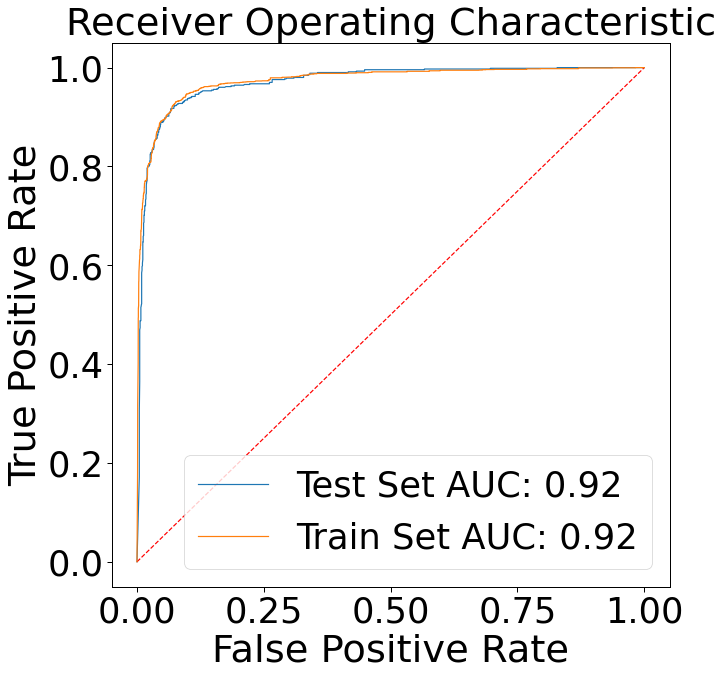

In [ ]:
roc(x_train_1f, x_test_1f, y_train_1f, y_test_1f, model_1f)

###Two Factor Model

Here we perform logisitic regression using our two factor model, with items determined by factor analysis. We can see the our one factor model using common codes has a sesitivty of about 93% and a specificity of about 88%.



In [ ]:
ll_2f, top_coeffs_2f, odds_ratio_matrix_2f, model_2f, cm_2f, sensitivity_2f, specificity_2f = logistic_regression(
    x_train_2f, x_test_2f, y_train_2f, y_test_2f)

Best: 0.922102 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.922061 (0.008845) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.922061 (0.008845) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.922061 (0.008845) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.922061 (0.008845) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.922061 (0.008845) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.922061 (0.008845) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.922019 (0.008891) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.922019 (0.008891) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.922102 (0.008944) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.921729 (0.009060) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.921729 (0.009060) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.920608 (0.009123) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.920691 (0.009469) wit

Let's visualize the accuracy of the one factor model.

<Figure size 432x288 with 0 Axes>

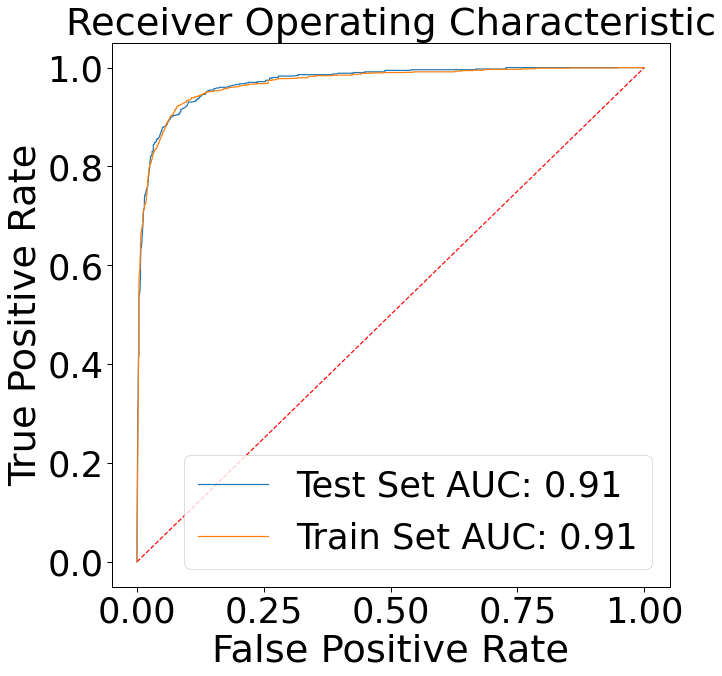

In [ ]:
roc(x_train_2f, x_test_2f, y_train_2f, y_test_2f, model_2f)

##Principal Componenet Analysis / Random Forest Classifier

Using the split 20% training and 80% test sets, we applied principal component analysis (PCA) with 2 components, although the scree plots informed that a single component would best capture the variance of the data. A random forest classifier was implemented with a maximum depth of 2. Next, we determined the largest factor contributors to the first component.

Of note, some argue that PCA is not the optimal choice for binary data like this.


The below function is used to determine the correct number of components to be used in PCA.

In [ ]:
def pca_2(data_frame_x):
    """
    Choose the number of components for PCA analysis.
    
    Parameters
    ----------
    data_frame_x : Pandas Dataframe 
      Column of x values to be used in PCA
    Returns
    -------
    scores_pca : Array
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data_frame_x)
    pca = PCA()
    pca.fit(scaled_features)

    plt.figure(figsize = (15, 15))
    evr = pca.explained_variance_ratio_.cumsum()
    plt.plot(range(1, scaled_features.shape[1]+1), evr, marker = 'o', linestyle = '--')
    plt.title('Explained Variance by Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.xlim((1, 10))
    plt.ylim((0, 0.8))
    knee = KneeLocator(
      range(0, 18), evr, curve="convex", direction="decreasing")  
    ncomponents = round(knee.knee, 0)
    pca = PCA(n_components = ncomponents)
    scores_pca = pca.fit_transform(scaled_features)
    return scores_pca


Here we can see the amount of variance attributed to the number of components. 

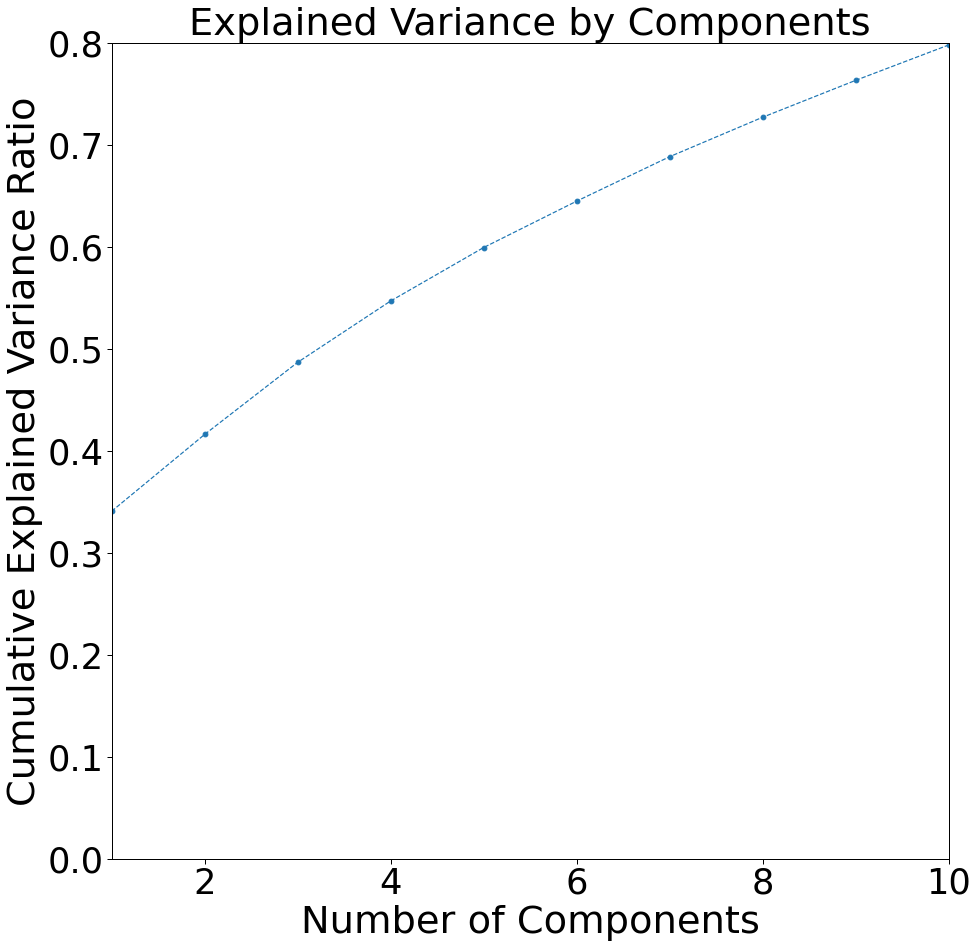

In [ ]:
scores_pca_fullset = pca_2(all_mods[all_coding_columns])

We performed PCA with 2 components. The below function performs and visualizes the result of PCA for a split dataset based on a Random Forest Classifier with a maximum depth of 2. 
Note: You may wish to alter your max depth to a higher number!

In [ ]:
def pca(x_train, x_test, y_train, y_test, rfc_depth):
    """
    Principal component analysis on ADOS codes.
    Determine what items are most important in characterizing the variance.
    Normalize the data using StandardScaler, then use the PCA function
    Only do this on values that are not null.

    Parameters
    ----------
    x_train : Pandas Dataframe 
        dataframe with dummy-code independent variables (training data)
    x_test : Pandas Dataframe
        dataframe with dummy-code independent variables (testing data)
    y_train : Pandas Dataframe
        dataframe with dummy-code dependent variables
        (training data)
    y_test : Pandas Dataframe
        dataframe with dummy-code dependent variables
        (training data)
    rfc_depth : Integer
        integer for max_depth in random forest classifier.

    Returns
    -------
    loadings_matrix : Pandas DataFrame
        dataframe with PC1 and PC2 loadings for each variable

    """
    sample_size = str(x_train_1f.shape[0]+x_test_1f.shape[0])
    pca = PCA(n_components=2)
    X_train_a = x_train.to_numpy()
    X_test_a = x_test.to_numpy()
    y_train_a = y_train.to_numpy().flatten()
    y_test_a = y_test.to_numpy().flatten()
    X_train_a = pca.fit_transform(X_train_a)
    X_test_a = pca.transform(X_test_a)
    classifier = RandomForestClassifier(max_depth=rfc_depth, random_state=0)
    classifier.fit(X_train_a, y_train_a)
    y_pred = classifier.predict(X_test_a)
    cm = metrics.confusion_matrix(y_test_a, y_pred)
    print(cm)
    accu = metrics.accuracy_score(y_test_a, y_pred)
    print('Accuracy', accu)
    accu_str = str(round(accu*100))


    # loadings of factors
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(
        loadings, columns=['PC1', 'PC2'], index=x_train.columns)
    print('Largest factor loadings for PC1', abs(
        loading_matrix['PC1']).nlargest(11))

    plt.figure(figsize=(6, 5))
    plt.rcParams.update({'font.size': 16})
    X_a = x_train.to_numpy()
    y_a = y_train.to_numpy().flatten()
    pca = PCA(n_components=2, whiten=True)
    pca.fit(X_a)
    X_pca_a = pca.transform(X_a)
    target_ids = range(0, 2)
    target_names = np.array(['Autism', 'Nonspectrum'])

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    # n_samples = str(len(x_test) + len(x_train))
    ax.set_title('Distinguishing Participants by Diagnosis \n in Modules 1-3' + \
      ' (N = ' + sample_size + ') distinguished at ' + accu_str + '% Accuracy')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    for i, c, label in zip(target_ids, 'rbyrgbcmykw', target_names):
        print(i, label)
        ax.scatter(X_pca_a[y_a == i, 0], X_pca_a[y_a == i, 1],
                   c=c, label=label)
    ax.legend()

    return loading_matrix

###One Factor Model

We find that we can, at 92% accuracy, distinguish individuals labeled as having autism from those labeled as nonspectrum by reducing the data to two principal components. 

Top contributors to the first principal component were (in order of most important): eye contact, attention to the examiner, prosodic intonation when speaking, social overtures, social response, sensory sensitivities, repetitive and restricted behaviors, and stereotyped language.

[[1245   61]
 [  80  623]]
Accuracy 0.9298158287705326
Largest factor loadings for PC1 eye_cont        0.731174
exp_attn        0.668940
inton           0.615549
soc_overture    0.591955
response        0.569199
sensory         0.535758
rrb             0.519356
stereo_lang     0.477302
imag            0.441925
facial_exp      0.423646
shared_enj      0.404079
Name: PC1, dtype: float64
0 Autism
1 Nonspectrum
Variable Weights Contributing to PCA 
                    PC1       PC2
eye_cont      0.731174 -0.180710
exp_attn      0.668940  0.493484
inton         0.615549 -0.210201
soc_overture  0.591955  0.023581
response      0.569199  0.026226
sensory       0.535758 -0.100596
rrb           0.519356 -0.290628
stereo_lang   0.477302 -0.332616
imag          0.441925  0.316113
facial_exp    0.423646  0.058099
shared_enj    0.404079  0.251938


<Figure size 432x360 with 0 Axes>

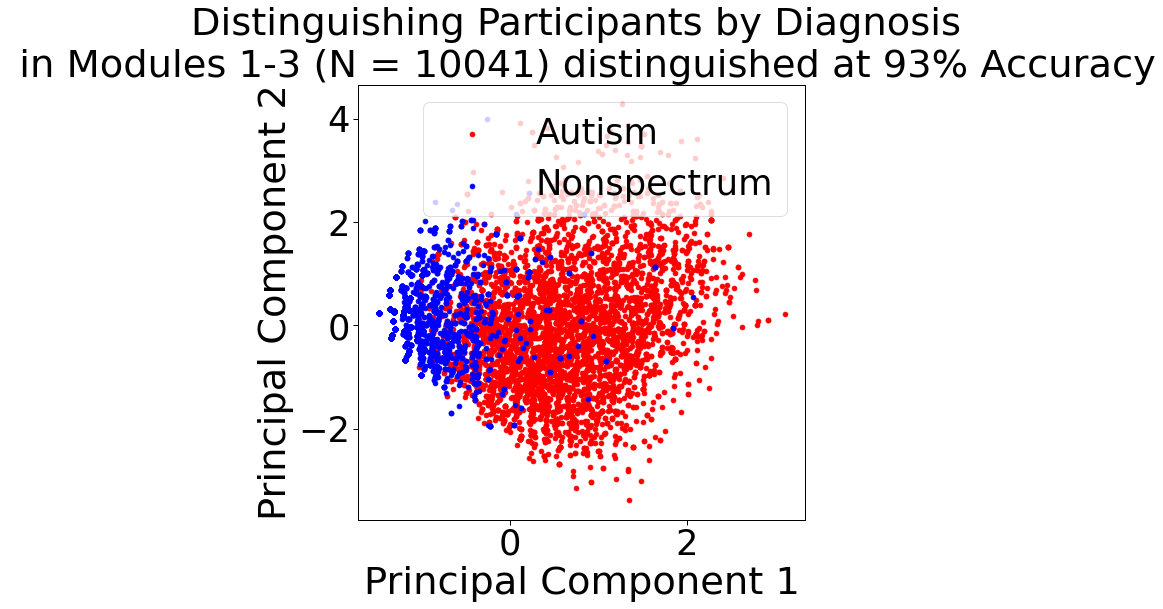

In [ ]:
pca_results = pca(x_train_1f, x_test_1f, y_train_1f, y_test_1f, 2)
print('Variable Weights Contributing to PCA \n',
      pca_results.sort_values(by='PC1', ascending=False))

###Two Factor Model

We find that we can, at 92% accuracy, distinguish individuals labeled as having autism from those labeled as nonspectrum by reducing the data to two principal components. 

Top contributors to the first principal component were (in order of most important): eye contact, attention to the examiner, social overtures, social response, repetitive and restricted behaviors, complex hand mannerisms, and facial expressions.

[[1210   96]
 [  79  624]]
Accuracy 0.9128919860627178
Largest factor loadings for PC1 eye_cont        0.748477
exp_attn        0.692480
soc_overture    0.588675
response        0.562555
rrb             0.514798
mannerisms      0.498784
facial_exp      0.424150
shared_enj      0.403843
echo            0.306049
Name: PC1, dtype: float64
0 Autism
1 Nonspectrum
Variable Weights Contributing to PCA 
                    PC1       PC2
eye_cont      0.748477 -0.157299
exp_attn      0.692480 -0.201080
soc_overture  0.588675 -0.095080
response      0.562555 -0.081991
rrb           0.514798  0.224977
mannerisms    0.498784  0.727132
facial_exp    0.424150 -0.158794
shared_enj    0.403843 -0.272695
echo          0.306049  0.189686


<Figure size 432x360 with 0 Axes>

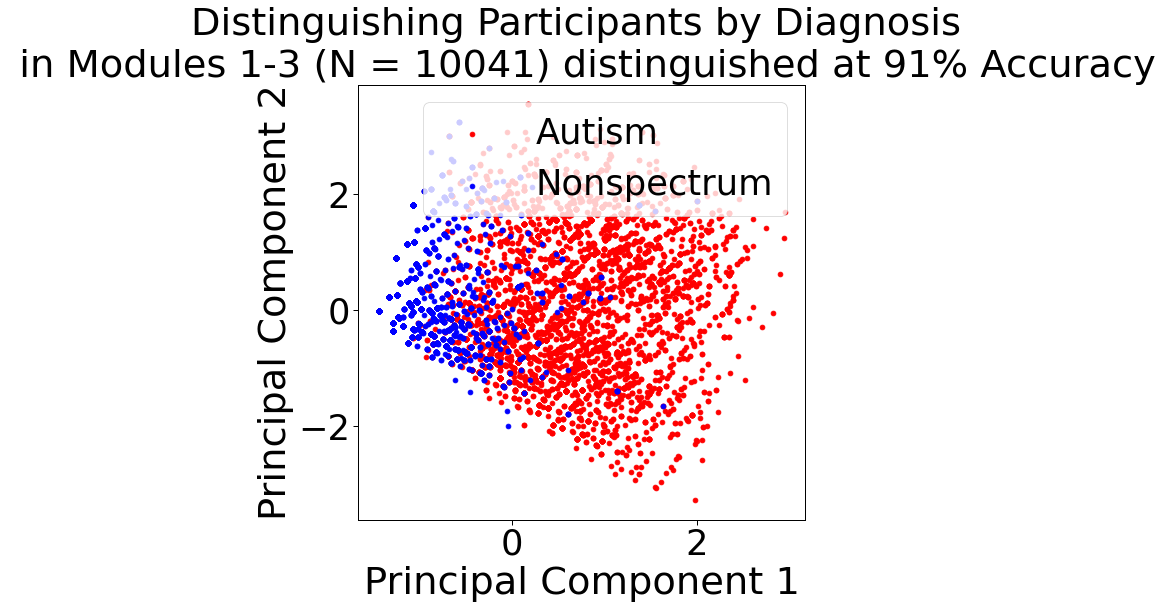

In [ ]:
pca_results = pca(x_train_2f, x_test_2f, y_train_2f, y_test_2f, 2)
print('Variable Weights Contributing to PCA \n',
      pca_results.sort_values(by='PC1', ascending=False))

#Validation of Published Algorithms

After performing exploratory factor analysis, confirmatory factor analysis, logistic regression, and principal componenet analysis on our novel common code models, we also use this large open-access dataset to validate the current published ADOS algorithms. 

The ADOS has 5 separate algorithms for modules 1-3, separated based on age and language of the assessee. All of the 5 models are 2 factor models, breaking item codes into Social codes and Restrictive/Repetitive Behavior (RRB) codes.

##Preparing the Datasets

To assess the published algorithms, we must select the relevant codes from each data set, not the common codes used in previous analyses. The below code generates dictionaries of the social affect and rrb codes used in each algorithm, codes selected using the ADOS assessment.

In [ ]:
# Published algorithm, mod 1 no words
mod1nv_model2_dict = list(['freq_voc','gest', 'eye_cont', 'facial_exp', 
                           'int_gaze','shared_enj', 'show', 'init_ji', 'res_ji',
                           'soc_overture','inton','sensory', 'mannerisms', 'rrb'])
# Published algorithm, mod 1 some words
mod1v_model2_dict = list(['freq_voc','point','gest', 'eye_cont', 'facial_exp', 
                        'int_gaze','shared_enj', 'show', 'init_ji',
                        'soc_overture','stereo_lang', 'sensory', 'mannerisms', 'rrb'])
# Published algorithm, mod 2 (used for both age groups <5, => 5)
mod2_model2_dict = list(['stereo_lang', 'point','gest', 'eye_cont', 'facial_exp', 
                              'shared_enj','show', 'init_ji','soc_overture',
                              'amt_soc_comm', 'rapport','sensory','mannerisms', 
                              'rrb'])
# Published algorithm, mod 3 
mod3_model2_dict = list(['stereo_lang', 'report','converse','gest', 'eye_cont', 
                          'facial_exp', 'shared_enj','soc_overture','soc_res',
                          'amt_soc_comm', 'rapport','sensory','mannerisms', 'rrb'])

To assess the sensitivity and specificity of each published ADOS module, we  generate datasets separated by algorithm.

###Module 1

In [ ]:
def algorithm_1(df, alg_num):
    """
    Selects ADOS items for algorithms for mod 1, both no words and some words.

    Parameters
    ----------
    df : Pandas DataFrame
        includes subjectkey, interview_age, and scoresumm_adosdiag as variables
    mod num : Integer
        number specifying few/no words (0) or some words (1)
    Returns
    -------
    dfD : Pandas DataFrame 
        dataframe with demographic codes, diagnostic labels, and
        condensed number of ADOS coding variables
    """

    # List of desired item variables
    similar_codes_strings = ['subjectkey', 'interview_age', 'sex', 'olang',
                             'fvoc','point','gest', 'ueye', 'faceo', 'gzsov',
                             'shrnj', 'show', 'sijnt', 'rjnt', 'qsov', 'inton', 
                             'stereo', 'usens', 'oman', 'urbeh','scoresumm_adosdiag',
                             'scoresumm_overalldiag']

    # Lists column names in dataframe
    col_names = list(df)

    # Only selects the columns from the dataframe that are in list of desired columns
    condensed_cols = [col for col in col_names if any(
        code_str in col for code_str in similar_codes_strings)]

    # Isolates columns from dataframe as new_df
    dfB = df[condensed_cols]

    # Renames the columns of new data set for coherence
    dfB.columns = ['subjectkey', 'interview_age', 'sex', 'module_lang',
                      'freq_voc', 'inton', 'stereo_lang', 'point',
                      'gest', 'eye_cont', 'facial_exp', 'int_gaze', 'shared_enj',
                      'show', 'init_ji','res_ji','soc_overture', 'sensory',
                      'mannerisms', 'rrb','scoresumm_adosdiag', 'scoresumm_overalldiag']

    # Identify demographics and diagnostic columns
    col_demo_and_diag = list(itertools.chain(demographics, diagnostic))

    # Coding items: not the demo or diag
    col_coding_new = [col for col in dfB.columns
                      if col not in col_demo_and_diag]

    # Removes data based on num provided when function called,
    # If 0, removes data of those who have some words
    # If 1, removes data of those who have no words
    if (alg_num == 1):
        dfB.module_lang.replace(to_replace=['0', '1', '2'], value=np.nan, inplace=True)
    elif (alg_num == 0):
        dfB.module_lang.replace(to_replace=['3', '4'], value=np.nan, inplace=True)

    # Calls previously used clean data function
    dfC = clean_data(dfB)
    # Calls previously used format datatype functions
    dfD = format_datatypes(dfC, col_coding_new)

    return dfC


Generates data for Module 1, no words

In [ ]:
mod1_pubnv_df = pd.read_csv('/content/ados1_201201.txt', delimiter="\t")
mod1_pubnv_df= extract_variables(mod1_pubnv_df)
mod1_pubnv_df = algorithm_1(mod1_pubnv_df,0)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Generates data for Module 1, some words

In [ ]:
mod1_pubv_df = pd.read_csv('/content/ados1_201201.txt', delimiter="\t")
mod1_pubv_df= extract_variables(mod1_pubv_df)
mod1_pubv_df = algorithm_1(mod1_pubv_df,1)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###Module 2

In [ ]:
def algorithm_2(df, alg_num):
    """
    Selects ADOS items for algorithms for mod 2, both for younger than 5 and 5 and older.

    Parameters
    ----------
    df : Pandas DataFrame
        includes subjectkey, interview_age, and scoresumm_adosdiag as variables
    alg num : Integer
        number specifying age(0-younger than 5) or 5 or older(1)
    Returns
    -------
    dfD : Pandas DataFrame 
        dataframe with demographic codes, diagnostic labels, and
        condensed number of ADOS coding variables
    """
    # List of desired item variables for algorithm
    similar_codes_strings = ['subjectkey', 'interview_age', 'sex',
                             'point','gest', 'ueye', 'faceo','shrnj', 'show', 'sijnt',
                             'qsov', 'arsoc', 'oqrap', 'stereo', 'usens', 'oman', 'urbeh',
                             'scoresumm_adosdiag','scoresumm_overalldiag']

    # Lists column names in dataframe
    col_names = list(df.columns)

    # Only selects the columns from the dataframe that are in above list
    condensed_cols = [col for col in col_names if any(
        code_str in col for code_str in similar_codes_strings)]

    # Isolates columns from dataframe as new_df
    dfB = df[condensed_cols]

    # Renames the columns of new data set
    dfB.columns = ['subjectkey', 'interview_age', 'sex', 'stereo_lang', 'point',
                      'gest', 'eye_cont', 'facial_exp', 'shared_enj',
                      'show', 'init_ji','soc_overture','amt_soc_comm', 'rapport',
                      'sensory','mannerisms', 'rrb','scoresumm_adosdiag', 'scoresumm_overalldiag']

    # Identify demographics and diagnostic columns
    col_demo_and_diag = list(itertools.chain(demographics, diagnostic))

    # Coding items: not the demo or diag
    col_coding_new = [col for col in dfB.columns
                      if col not in col_demo_and_diag]

    # Sets age to int to allow filtering
    dfB.interview_age[0] = 0
    dfB['interview_age'] = dfB['interview_age'].astype('int32')
    
    # Removes data based on age of assessee
    # If 0, removes those 5 and older
    # If 1, removes those younger than 5
    if (alg_num == 1):
        dfB.loc[dfB.interview_age<60,'interview_age']=np.nan
    elif (alg_num == 0):
        dfB.loc[dfB.interview_age>59,'interview_age']=np.nan

    dfC = clean_data(dfB)
    dfD = format_datatypes(dfC, col_coding_new)

    return dfD


Generates Data for Module 2, younger than 5

In [ ]:
mod2_pubyoung_df = pd.read_csv('/content/ados2_201201.txt', delimiter="\t")
mod2_pubyoung_df= extract_variables(mod2_pubyoung_df)
mod2_pubyoung_df = algorithm_2(mod2_pubyoung_df, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

Generates Data for Module 2, aged 5 and older

In [ ]:
mod2_pubold_df = pd.read_csv('/content/ados2_201201.txt', delimiter="\t")
mod2_pubold_df= extract_variables(mod2_pubold_df)
mod2_pubold_df = algorithm_2(mod2_pubold_df, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

###Module 3

In [ ]:
def algorithm_3(df):
    """
    Selects ADOS items for algorithms for mod 3.

    Parameters
    ----------
    df : Pandas DataFrame
        includes subjectkey, interview_age, and scoresumm_adosdiag as variables
    Returns
    -------
    dfD : Pandas DataFrame 
        with demographic codes, diagnostic labels, and
        condensed number of ADOS coding variables
    """
    # List of desired similar variables
    similar_codes_strings = ['subjectkey', 'interview_age', 'sex',
                             'reprt','convs', 'gest', 'ueye', 'facee','shrnj', 
                             'qsov', 'qsres', 'arsoc', 'oqrap', 'stereo', 'usens', 
                             'oman', 'topic',
                             'scoresumm_adosdiag','scoresumm_overalldiag']

    # Lists column names in dataframe
    col_names = list(df.columns)

    # Only selects the columns from the dataframe that are in above list
    condensed_cols = [col for col in col_names if any(
        code_str in col for code_str in similar_codes_strings)]

    # Isolates columns from dataframe as new_df
    dfB = df[condensed_cols]

    # Renames the columns of new data set
    dfB.columns = ['subjectkey', 'interview_age', 'sex', 'stereo_lang', 'report',
                      'converse','gest', 'eye_cont', 'facial_exp', 'shared_enj',
                      'soc_overture','soc_res','amt_soc_comm', 'rapport',
                      'sensory','mannerisms', 'rrb','scoresumm_adosdiag', 'scoresumm_overalldiag']

    # Identify demographics and diagnostic columns
    col_demo_and_diag = list(itertools.chain(demographics, diagnostic))

    # Coding items: not the demo or diag
    col_coding_new = [col for col in dfB.columns
                      if col not in col_demo_and_diag]

    dfC = clean_data(dfB)
    dfD = format_datatypes(dfC, col_coding_new)

    return dfD

Generates data for Module 3

In [ ]:
mod3_pub_df = pd.read_csv('/content/ados3_201201.txt', delimiter="\t")
mod3_pub_df= extract_variables(mod3_pub_df)
mod3_pub_df = algorithm_3(mod3_pub_df)

##Summary Stats

Again, we want to visualize and understand the distirubtion of the data selected to validate the published algorithms.

In [ ]:
def summ_stats_published(df):
  """
  Summary stats pulled from dataframe, not separated by module
  
  Parameters
  ----------
  df: Pandas Dataframe
  Returns
  -------
  sex_summ : Pandas Dataframe 
      of sex stats by module and diagnosis
  age_summ : Pandas Dataframe
      of age stats by module and diagnosis
  """
  sex_summ = df.groupby(['scoresumm_adosdiag'])['sex'].value_counts()
  age_summ = df.groupby(['scoresumm_adosdiag'])['interview_age'].describe()

  return sex_summ, age_summ

In [ ]:
sex1nv, age1nv = summ_stats_published(mod1_pubnv_df)
sex1v, age1v = summ_stats_published(mod1_pubv_df)
sex2young, age2young = summ_stats_published(mod2_pubyoung_df)
sex2old, age2old = summ_stats_published(mod2_pubold_df)
sex3, age3 = summ_stats_published(mod3_pub_df)

Below is a table of the ages and sex layout of the data, separated by published algorithm.

In [ ]:
table = go.Figure(data=[go.Table(
    columnwidth = [500],
header=dict(values= ['Module','Diagnosis','Count', 'N of Females',
                      'Age \n (months, mean)', 'Age \n (months, std)'],
            line_color='red', fill_color='lightblue', align=['center', 'center'],
            font_size = 20, height=40),
cells = dict(values=[['Mod 1, no words','','Mod 1, some words','','Mod 2, <5','','Mod 2, 5+','','Mod 3',''],
                      ['Autism', 'Nonspectrum', 'Autism', 'Nonspectrum','Autism', 'Nonspectrum',
                      'Autism', 'Nonspectrum','Autism', 'Nonspectrum',],
                      [age1nv['count'].loc[0],age1nv['count'].loc[1], age1v['count'].loc[0],
                      age1v['count'].loc[1], age2young['count'].loc[0], age2young['count'].loc[1],
                      age2old['count'].loc[0], age2old['count'].loc[1], age3['count'].loc[0],
                      age3['count'].loc[1]],
                      [sex1nv.loc[0,'F'],sex1nv.loc[1,'F'], sex1v.loc[0,'F'],
                      sex1v.loc[1,'F'], sex2young.loc[0,'F'], sex2young.loc[1,'F'],
                      sex2old.loc[0,'F'], sex2old.loc[1,'F'], sex3.loc[0,'F'],
                      sex3.loc[1,'F']],
                      [round(age1nv['mean'].loc[0]),round(age1nv['mean'].loc[1]), round(age1v['mean'].loc[0]),
                      round(age1v['mean'].loc[1]), round(age2young['mean'].loc[0]), round(age2young['mean'].loc[1]),
                      round(age2old['mean'].loc[0]), round(age2old['mean'].loc[1]), round(age3['mean'].loc[0]),
                      round(age3['mean'].loc[1])],
                      [round(age1nv['std'].loc[0]),round(age1nv['std'].loc[1]), round(age1v['std'].loc[0]),
                      round(age1v['std'].loc[1]), round(age2young['std'].loc[0]), round(age2young['std'].loc[1]),
                      round(age2old['std'].loc[0]), round(age2old['std'].loc[1]), round(age3['std'].loc[0]),
                      round(age3['std'].loc[1])]],
              line_color='red', fill_color='white', align='center',
              font_size=18, height=40))])
table.update_layout(width=1000, height=750)
table.show()

##Logistic Regression

To perform logistic regression on each separate algorithm's validity, we must split the data sets into a training set and testing set. Again, note this should be done with data sets with over 500 entries, interpret results for Module 1, some words, with caution. 

In [ ]:
# Splitting Module 1 no words
x_train_pub1nv, x_test_pub1nv, y_train_pub1nv, y_test_pub1nv = split_dataset(
    mod1_pubnv_df, mod1nv_model2_dict, diagnostic[0])

# Splitting Module 1, some words
x_train_pub1v, x_test_pub1v, y_train_pub1v, y_test_pub1v = split_dataset(
    mod1_pubv_df, mod1v_model2_dict, diagnostic[0])

# Splitting Module 2, younger than 5
x_train_pub2young, x_test_pub2young, y_train_pub2young, y_test_pub2young, = split_dataset(
    mod2_pubyoung_df, mod2_model2_dict, diagnostic[0])

# Splitting Module 2, 5 and older
x_train_pub2old, x_test_pub2old, y_train_pub2old, y_test_pub2old, = split_dataset(
    mod2_pubold_df, mod2_model2_dict, diagnostic[0])

# Splitting Module 3
x_train_pub3, x_test_pub3, y_train_pub3, y_test_pub3, = split_dataset(
    mod3_pub_df, mod3_model2_dict, diagnostic[0])


We can then execute logistic regression, using the same function as was used on the common code models.

###Module 1

Performs logisitic regression for Module 1, no words

In [ ]:
ll_mod1_pubnv, top_coeffs_mod1_pubnv, odds_ratio_matrix_mod1_pubnv, model_mod1_pubnv, cm_mod1_pubnv, sensitivity_mod1_pubnv, specificity_mod1_pubnv = logistic_regression(
    x_train_pub1nv, x_test_pub1nv, y_train_pub1nv, y_test_pub1nv)

Best: 0.959613 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.959048 (0.010972) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.959048 (0.010972) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.959048 (0.010972) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.959048 (0.010972) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.959048 (0.010972) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.958860 (0.011186) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.959613 (0.010981) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.959613 (0.010981) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.958854 (0.010718) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.958288 (0.010870) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.958288 (0.010870) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.951118 (0.008559) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.959230 (0.009167) wit

Performs logisitic regression for Module 1, some words

In [ ]:
ll_mod1_pubv, top_coeffs_mod1_pubv, odds_ratio_matrix_mod1_pubv, model_mod1_pubv, cm_mod1_pubv, sensitivity_mod1_pubv, specificity_mod1_pubv = logistic_regression(
    x_train_pub1v, x_test_pub1v, y_train_pub1v, y_test_pub1v)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.



Best: 0.978519 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.978519 (0.043027) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.978519 (0.043027) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.967778 (0.049304) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.978519 (0.043027) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.978519 (0.043027) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.967778 (0.049304) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.978519 (0.043027) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.978519 (0.043027) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.967778 (0.049304) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.967778 (0.049304) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.967778 (0.049304) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.957778 (0.051831) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.957778 (0.051831) wit

###Module 2

Performs logisitic regression for module 2, younger than 5

In [ ]:
ll_mod2_pubyoung, top_coeffs_mod2_pubyoung, odds_ratio_matrix_mod2_pubyoung, model_mod2_pubyoung, cm_mod2_pubyoung, sensitivity_mod2_pubyoung, specificity_mod2_pubyoung = logistic_regression(
    x_train_pub2young, x_test_pub2young, y_train_pub2young, y_test_pub2young)

Best: 0.906270 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.903391 (0.013520) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.903391 (0.013520) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.903239 (0.013741) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.903088 (0.013240) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.903088 (0.013240) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.902936 (0.013557) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.903239 (0.013749) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.903239 (0.013749) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.902633 (0.013721) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.906270 (0.016021) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.906270 (0.016021) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.901117 (0.015711) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.891416 (0.017533) wit

Performs logisitic regression for module 2, younger than 5

In [ ]:
ll_mod2_pubold, top_coeffs_mod2_pubold, odds_ratio_matrix_mod2_pubold, model_mod2_pubold, cm_mod2_pubold, sensitivity_mod2_pubold, specificity_mod2_pubold = logistic_regression(
    x_train_pub2old, x_test_pub2old, y_train_pub2old, y_test_pub2old)

Best: 0.984188 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.978570 (0.016577) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.978570 (0.016577) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.978570 (0.016577) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.979083 (0.016518) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.979083 (0.016518) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.979596 (0.015956) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.981127 (0.014038) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.981127 (0.014038) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.979596 (0.015926) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.984188 (0.014459) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.984188 (0.014459) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.954545 (0.022575) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.942300 (0.024625) wit

###Module 3

Performs logisitic regression for Module 3

In [ ]:
ll_mod3_pub, top_coeffs_mod3_pub, odds_ratio_matrix_mod3_pub, model_mod3_pub, cm_mod3_pub, sensitivity_mod3_pub, specificity_mod3_pub = logistic_regression(
    x_train_pub3, x_test_pub3, y_train_pub3, y_test_pub3)

Best: 0.991482 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.991482 (0.004189) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.991482 (0.004189) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.991482 (0.004189) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.991226 (0.004049) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.991226 (0.004049) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.990800 (0.004204) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.990545 (0.004283) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.990545 (0.004283) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.986541 (0.004844) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.984497 (0.005272) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.984497 (0.005272) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.970271 (0.008146) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.971465 (0.007163) wit

##Common Code Models: By Module

To compare the sensitivity and specificity of the original algorithms to our common code models, we first again separate and split the data by module. Then we must perform logisitic regression on the separated data. To streamline this process for the common code models, we define a function that splits the data and runs logisticc regression.

In [ ]:
def byMod(df, dictionary, ycolumn):
    """
    Performs logistic regression for each module separately, this function
    splits a given dataset and then performs logistic regression on the split
    data.

    Parameters
    ----------
    df : Pandas DataFrame
        includes subjectkey, interview_age, and scoresumm_adosdiag as variables
    dictionary : List of strings
        list of variables to be used in logisitic regression model as x columns
    ycolumn : List of strings
        list of variables in diagnostic column, y data
    Returns
 -------
    ll : 
    top_coeffs : Pandas Dataframe
        coefficients over 0.5 factor loading
    odds_ratio_matrix : Array
        exponential matrix
    model : linear_model
        logistic regression trained model
    cm : Array
        confusion matrix
    sensitivity1 : Float
        float of sensitivity of log reg model
    specificity1 : Float
        float of specificity of log reg model
    """
    x_train, x_test, y_train, y_test = split_dataset(
        df, dictionary, ycolumn[0])
    ll, top_coeffs, odds_ratio_matrix, f2, cm, sensitivity1, specificity1 = logistic_regression(
        x_train, x_test, y_train, y_test)
    
    return ll, top_coeffs, odds_ratio_matrix, f2, cm, sensitivity1, specificity1


We will call the above function for Modules 1-3 for both the one factor model and the two factor model.

In [ ]:
%%capture
m11ll, m11top_coeffs, m11odds_ratio_matrix, m11model, m11cm, m11sensitivity, m11specificity = byMod(mod1_df, list(all_high_loadings_f1), diagnostic)
m21ll, m21top_coeffs, m21odds_ratio_matrix, m21model, m21cm, m21sensitivity, m21specificity = byMod(mod2_df, list(all_high_loadings_f1), diagnostic)
m31ll, m31top_coeffs, m31odds_ratio_matrix, m31model, m31cm, m31sensitivity, m31specificity = byMod(mod3_df, list(all_high_loadings_f1), diagnostic)

m12ll, m12top_coeffs, m12odds_ratio_matrix, m12model, m12cm, m12sensitivity, m12specificity = byMod(mod1_df, list(all_high_loadings_f2), diagnostic)
m22ll, m22top_coeffs, m22odds_ratio_matrix, m22model, m22cm, m22sensitivity, m22specificity = byMod(mod2_df, list(all_high_loadings_f2), diagnostic)
m32ll, m32top_coeffs, m32odds_ratio_matrix, m32model, m32cm, m32sensitivity, m32specificity = byMod(mod3_df, list(all_high_loadings_f2), diagnostic)


##Comparing the Published Models and Common Code Models

In [ ]:
lrTable = pd.DataFrame({'Modules':['All Modules','Module 1 no words','Module 1 some words',
                                   'Module 2 below 5', 'Module 2, 5 and up', 'Module 3'],
                        'Published: Sens':['',round(sensitivity_mod1_pubnv,3), round(sensitivity_mod1_pubv,3),
                                      round(sensitivity_mod2_pubyoung,3), round(sensitivity_mod2_pubold,3),
                                      round(sensitivity_mod3_pub,3)],
                       'Published: Spec':['', round(specificity_mod1_pubnv,3), round(specificity_mod1_pubv,3),
                                      round(specificity_mod2_pubyoung,3), round(specificity_mod2_pubold,3),
                                      round(specificity_mod3_pub,3)],
                       '1 Factor: Sens':[round(sensitivity_1f,3), '', round(m11sensitivity,3), '', round(m21sensitivity,3),
                                      round(m31sensitivity,3)], 
                       '1 Factor: Spec':[round(specificity_1f,3), '', round(m11specificity,3), '',round(m21specificity,3),
                                      round(m31specificity,3)],
                       '2 Factor: Sens':[round(sensitivity_2f,3), '', round(m12sensitivity,3), '', round(m22sensitivity,3),
                                      round(m32sensitivity,3)], 
                       '2 Factor: Spec':[round(specificity_2f,3), '', round(m12specificity,3), '', round(m22specificity,3),
                                      round(m32specificity,3)]})

Below is a table showing:

1) 2-factor sensitivity and specificity for the published algorithms (1:5).

2) 1-factor sensitivity and specificity for our model (3 algorithms for each module, along with a single algorithm for all modules).

3) 2-factor sensivitiy and specificity for our model.

In [ ]:
print(tabulate(lrTable,headers="keys"))

    Modules              Published: Sens    Published: Spec    1 Factor: Sens    1 Factor: Spec    2 Factor: Sens    2 Factor: Spec
--  -------------------  -----------------  -----------------  ----------------  ----------------  ----------------  ----------------
 0  All Modules                                                0.95              0.889             0.94              0.889
 1  Module 1 no words    0.961              0.879
 2  Module 1 some words  1.0                1.0                0.981             0.853             0.984             0.853
 3  Module 2 below 5     0.912              0.952
 4  Module 2, 5 and up   1.0                0.87               0.888             0.925             0.865             0.911
 5  Module 3             0.997              0.983              0.961             0.885             0.966             0.873


#Conclusions: A Proof of Concept Project

1. Statistical power and the types of analyses we can conduct are bolstered by large datasets
2. Researchers have an obligation to make their research accessible to empower research discovery. This is especially true for taxpayer-funded research!
3. With simple machine learning algorithms and 10,000 samples, we were able to label children as 'autistic' or not based on simple 4-point clinical scale (0-3) rating features of behavior (e.g., eye contact, attention directed towards the examiner, and atypical intonation) with strong accuracy.
4. We encourage others to use our analyses as a blueprint for their own exploration of open-access ADOS data.

#Limitations

1. Unfortunately, there were very few samples labeled as having a non-autism neurodevelopmental disorder (NDD, n = 99). This prevented important consideration of sensitivity/specificity of algorithm codes, to evaluate how well we can distinguish traits of autism from those demonstrated in other neurodevelopmental disorders.